In [1]:
!pip install ultralytics
!pip install Roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.5/783.5 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install -U albumentations

In [3]:
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
import torch
import random
import shutil


In [4]:
# Download the dataset

rf = Roboflow(api_key="KhV6y3SVx0M66EFe23Vv")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(9)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-9 in yolov9:: 100%|██████████| 636/636 [00:00<00:00, 2041.69it/s]


In [5]:
# Get class count

def count_classes(base_dir, class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for root, _, files in os.walk(base_dir):
        if 'labels' in root:  # Process only the 'labels' directories
            for label_file in files:
                with open(os.path.join(root, label_file), 'r') as file:
                    lines = file.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])
                        class_counts[class_names[class_id]] += 1

    print(class_counts)
    return class_counts

In [6]:
# Plot the class count

def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in YOLO Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

{'ball': 272, 'goalkeeper': 235, 'player': 6229, 'referee': 718}


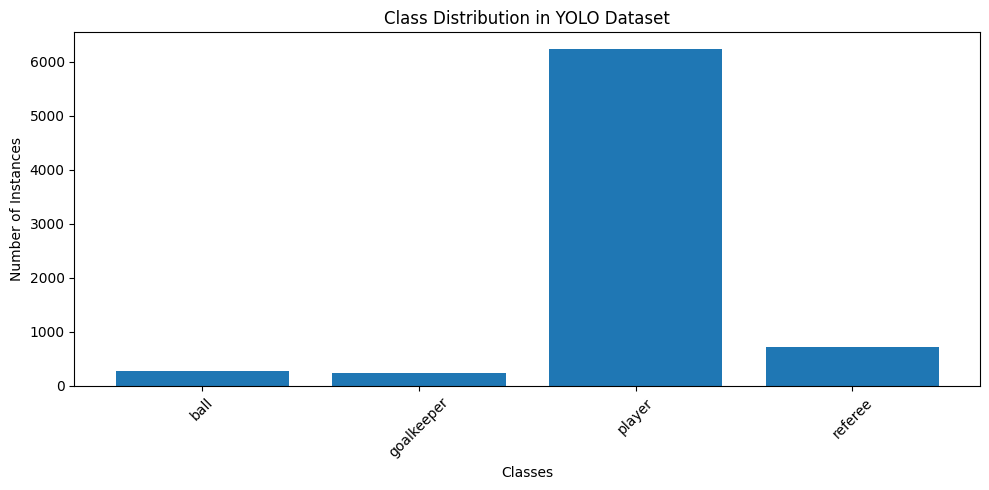

In [7]:
base_dir = '/content/football-players-detection-9'
class_names = ['ball', 'goalkeeper', 'player', 'referee']  # Update with your actual class names

original_class_counts  = count_classes(base_dir, class_names)
plot_class_distribution(original_class_counts )

In [8]:
# Define augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomCrop(width=450, height=450, p=0.5),
    A.GaussianBlur(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.OneOf([
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
        A.RandomFog(p=0.2),
        A.RandomSunFlare(p=0.2)
    ], p=0.3),  # Add weather augmentation with a 30% probability
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [9]:
!mkdir augmented_dataset

In [10]:
# Define paths
base_dir = '/content/football-players-detection-9'
output_dir = '/content/augmented_dataset'
class_names = ['ball', 'goalkeeper', 'player', 'referee']
classes_to_augment = ['ball', 'goalkeeper', 'referee']

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [11]:
# Get the image, bboxes and class label for each image in the dataset

def load_image_and_labels(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    with open(label_path, 'r') as file:
        labels = file.readlines()
    bboxes = []
    class_labels = []
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.split())
        class_labels.append(class_names[int(class_id)])
        bboxes.append([x_center, y_center, width, height])
    return image, bboxes, class_labels, h, w

In [12]:
# Save the augmented label and image

def save_augmented_image_and_labels(image, bboxes, class_labels, original_image_path, original_label_path, output_image_dir, output_label_dir, counter):
    image_name = os.path.splitext(os.path.basename(original_image_path))[0]
    label_name = os.path.splitext(os.path.basename(original_label_path))[0]

    augmented_image_path = os.path.join(output_image_dir, f"{image_name}_aug_{counter}.jpg")
    augmented_label_path = os.path.join(output_label_dir, f"{label_name}_aug_{counter}.txt")

    # Convert the tensor image back to a NumPy array
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).cpu().numpy()

    # Ensure the image is in uint8 format and within valid range
    image = np.clip(image, 0, 255).astype(np.uint8)


    cv2.imwrite(augmented_image_path, image)

    with open(augmented_label_path, 'w') as file:
        for bbox, class_label in zip(bboxes, class_labels):
            class_id = class_names.index(class_label)
            file.write(f"{class_id} " + " ".join(map(str, bbox)) + "\n")

In [13]:
# Process each directory
for folder in ['test', 'train', 'valid']:
    image_dir = os.path.join(base_dir, folder, 'images')
    label_dir = os.path.join(base_dir, folder, 'labels')

    output_image_dir = os.path.join(output_dir, folder, 'images')
    output_label_dir = os.path.join(output_dir, folder, 'labels')

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for label_file in tqdm(os.listdir(label_dir)):
        label_path = os.path.join(label_dir, label_file)
        image_path = os.path.join(image_dir, label_file.replace('.txt', '.jpg'))

        image, bboxes, class_labels, h, w = load_image_and_labels(image_path, label_path)

        if any(cls in class_labels for cls in classes_to_augment):
            for i in range(10):  # Number of augmentations per image
                augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
                augmented_image = augmented['image']
                augmented_bboxes = augmented['bboxes']
                augmented_class_labels = augmented['class_labels']

                save_augmented_image_and_labels(augmented_image, augmented_bboxes, augmented_class_labels, image_path, label_path, output_image_dir, output_label_dir, i)

print("Augmentation complete.")

100%|██████████| 43/43 [01:55<00:00,  2.69s/it]

Augmentation complete.


{'ball': 1580, 'goalkeeper': 1269, 'player': 37005, 'referee': 4015}


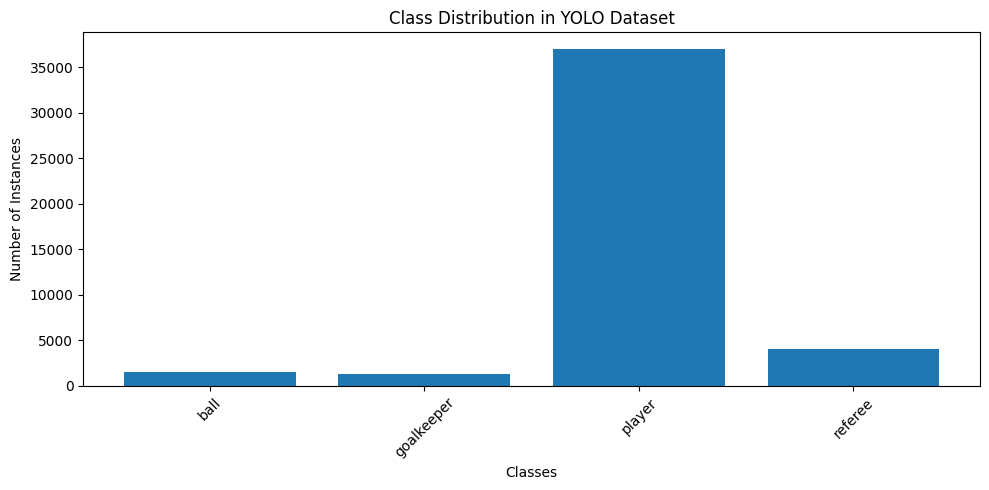

In [14]:
#Check the new class distribution after augmentations

base_dir = '/content/augmented_dataset'
class_names = ['ball', 'goalkeeper', 'player', 'referee']  # Update with your actual class names

augmented_class_counts  = count_classes(base_dir, class_names)
plot_class_distribution(augmented_class_counts )

In [15]:
# Plot class distributions
def plot_combined_class_distribution(original_counts, augmented_counts, class_names, title):
    labels = class_names
    original_values = [original_counts[cls] for cls in class_names]
    augmented_values = [augmented_counts[cls] for cls in class_names]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, original_values, width, label='Original')
    rects2 = ax.bar(x + width/2, augmented_values, width, label='Augmented')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Instances')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar in *rects*, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.xticks(rotation=45)
    plt.show()

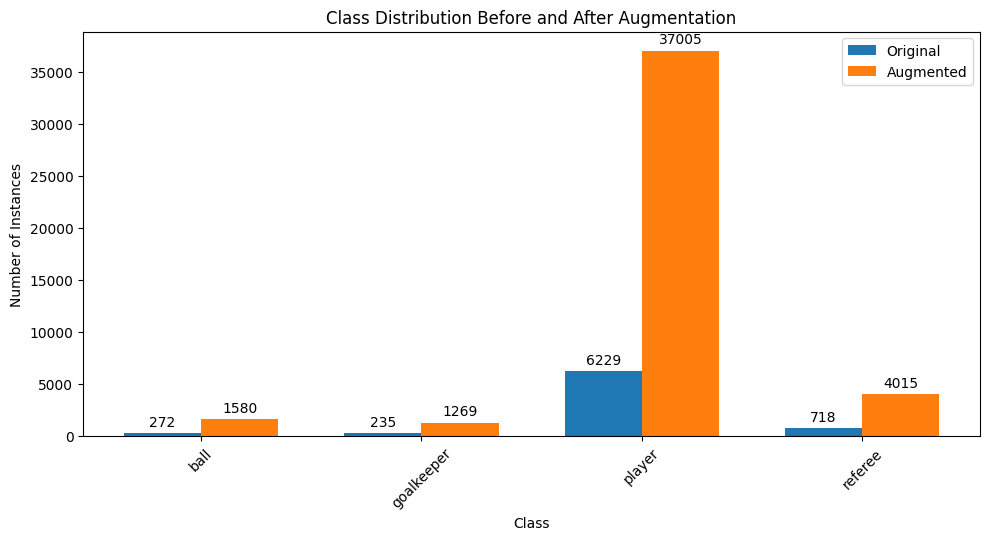

In [16]:
# plot combined class distribution

plot_combined_class_distribution(original_class_counts, augmented_class_counts, class_names, 'Class Distribution Before and After Augmentation')

In [17]:
def load_images_from_folder(folder, num_images=10):
    images = []
    filenames = sorted(os.listdir(folder))[:num_images]
    random_filenames = random.sample(filenames, num_images)
    for filename in random_filenames:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [18]:
def display_images(original_images, augmented_images):
    num_images = min(len(original_images), len(augmented_images))
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image", fontsize = 10)
        plt.axis('off')

        # Augmented image
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(augmented_images[i])
        plt.title("Augmented Image", fontsize = 10)
        plt.axis('off')

    plt.show()

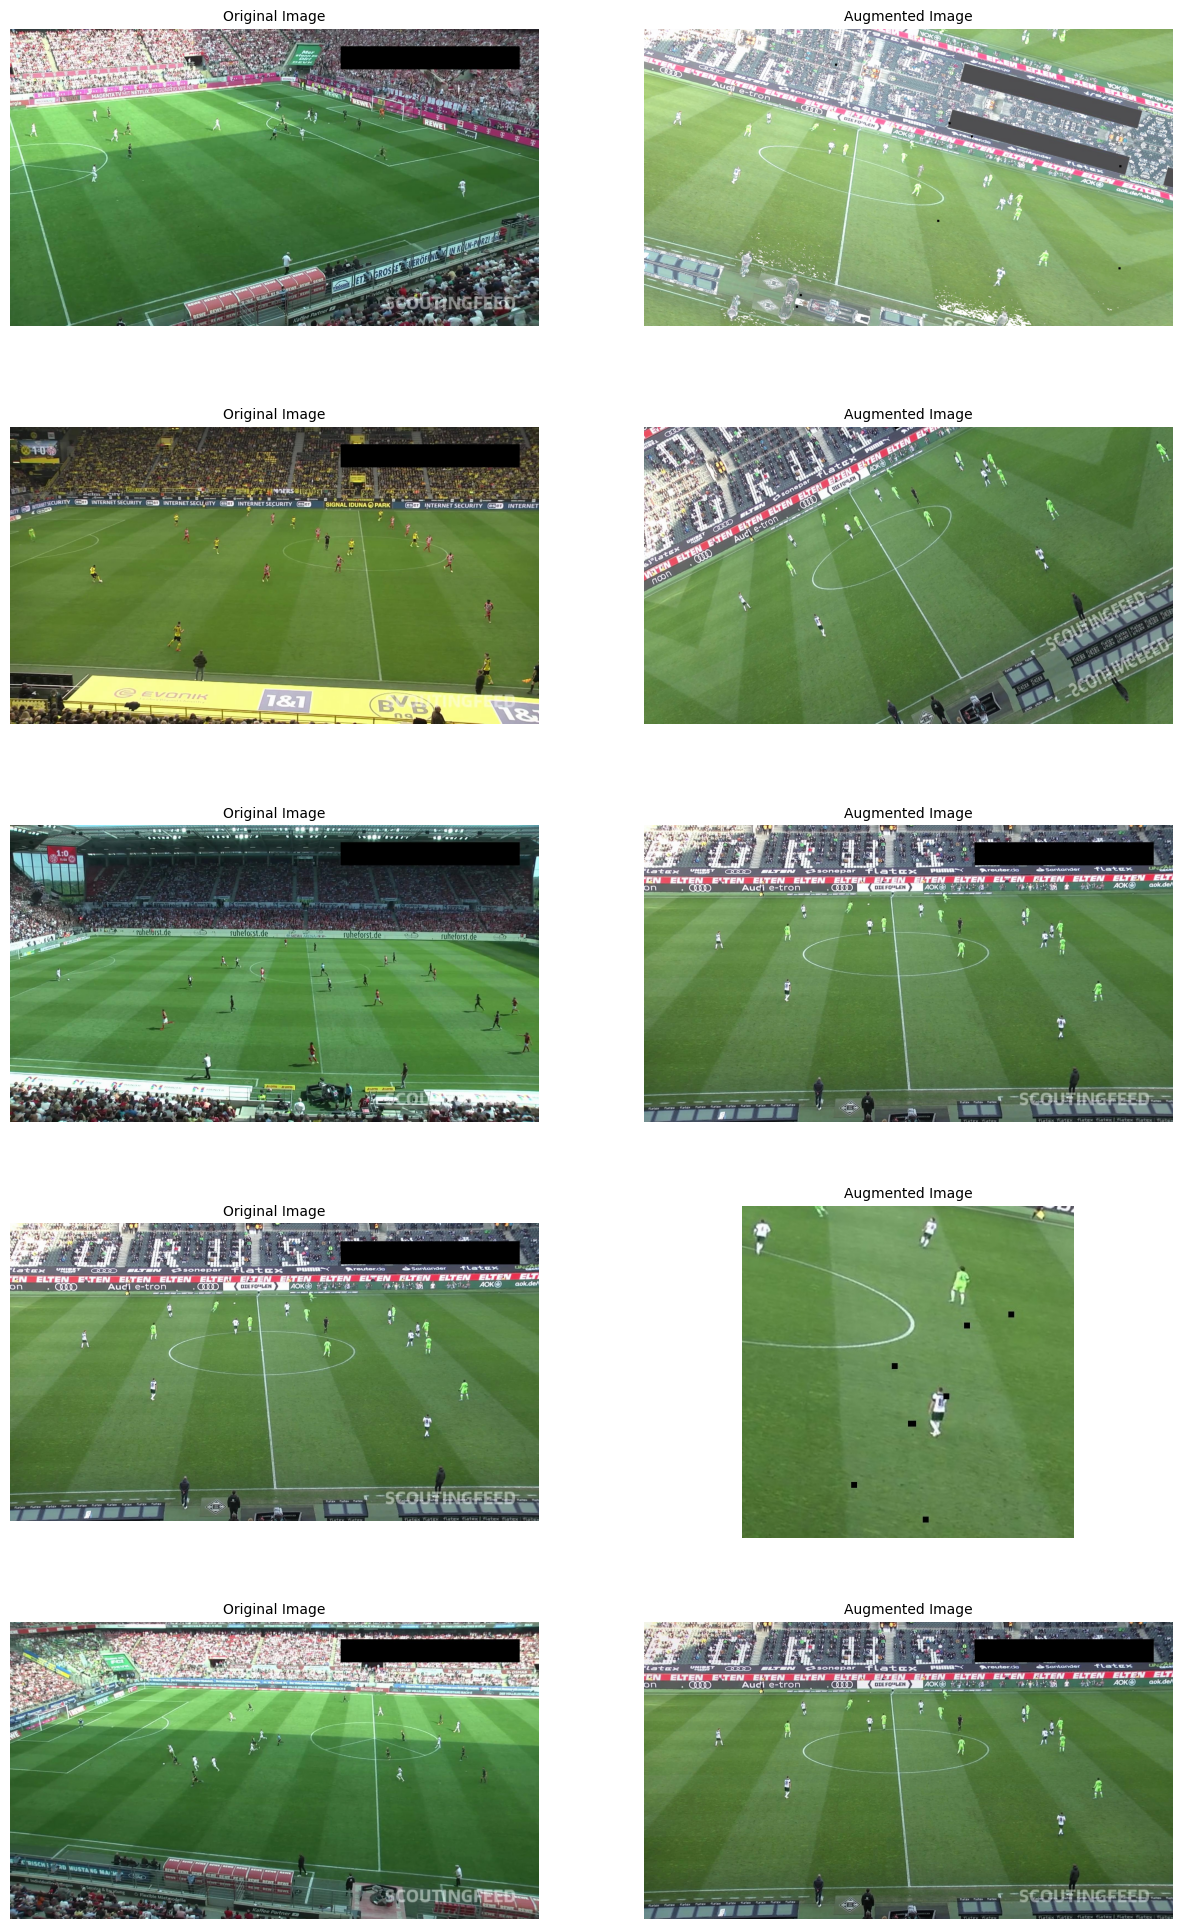

In [19]:
# Load images from the original dataset
original_image_folder = '/content/football-players-detection-9/test/images'
original_images = load_images_from_folder(original_image_folder, num_images=5)

# Load images from the augmented dataset
augmented_image_folder = '/content/augmented_dataset/test/images'
augmented_images = load_images_from_folder(augmented_image_folder, num_images=5)

# Display original and augmented images
display_images(original_images, augmented_images)

In [20]:
# Merge the two datasets

def merge_datasets(dataset1_dir, dataset2_dir, output_dir):
    for folder in ['train', 'valid', 'test']:
        for sub_folder in ['images', 'labels']:
            # Create the output directories if they don't exist
            output_sub_dir = os.path.join(output_dir, folder, sub_folder)
            os.makedirs(output_sub_dir, exist_ok=True)

            # Merge dataset1
            input_sub_dir1 = os.path.join(dataset1_dir, folder, sub_folder)
            for file_name in tqdm(os.listdir(input_sub_dir1), desc=f'Merging {folder}/{sub_folder} from dataset1'):
                source_path = os.path.join(input_sub_dir1, file_name)
                dest_path = os.path.join(output_sub_dir, file_name)
                shutil.copy2(source_path, dest_path)

            # Merge dataset2
            input_sub_dir2 = os.path.join(dataset2_dir, folder, sub_folder)
            for file_name in tqdm(os.listdir(input_sub_dir2), desc=f'Merging {folder}/{sub_folder} from dataset2'):
                source_path = os.path.join(input_sub_dir2, file_name)
                dest_path = os.path.join(output_sub_dir, file_name)
                # Handle potential filename conflicts
                base, ext = os.path.splitext(file_name)
                counter = 1
                while os.path.exists(dest_path):
                    new_file_name = f"{base}_{counter}{ext}"
                    dest_path = os.path.join(output_sub_dir, new_file_name)
                    counter += 1
                shutil.copy2(source_path, dest_path)

    print("Datasets merged successfully.")

In [21]:
# Define the paths to datasets
dataset1_dir = '/content/football-players-detection-9'
dataset2_dir = '/content/augmented_dataset'
output_dir = '/content/merged_dataset'

# Merge the datasets
merge_datasets(dataset1_dir, dataset2_dir, output_dir)

Merging test/labels from dataset2: 100%|██████████| 190/190 [00:00<00:00, 4939.74it/s]

Datasets merged successfully.


In [24]:
model = YOLO('yolov9m.pt')

100%|██████████| 39.1M/39.1M [00:00<00:00, 125MB/s]

WARNING ⚠️ yolov9m.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.7s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



In [ ]:
results=model.train(data="/content/data.yaml", epochs=40, imgsz=640, batch=16)

New https://pypi.org/project/ultralytics/8.2.36 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.35 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=/content/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1    171648  ultralytics.nn.modules.block.RepNCSPELAN4    [64, 128, 128, 64, 1]         
  3                  -1  1    276960  ultralytics.nn.modules.block.AConv           [128, 240]                    
  4                  -1  1    629520  ultralytics.nn.modules.block.RepNCSPELAN4    [240, 240, 240, 120, 1]       
  5                  -1  1    778320  ultralytics.nn.modules.block.AConv           [240, 360]                    
  6                  -1  1   1414080  ultralytics.nn.modules.block.RepNCSPELAN4    [360, 360, 360, 180, 1]       
  7                  -1  1   1556160  ultralytics

train: Scanning /content/football-players-detection-9/train/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 1550.79it/s]

train: New cache created: /content/football-players-detection-9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/football-players-detection-9/valid/labels... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 1616.98it/s]

val: New cache created: /content/football-players-detection-9/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0005), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/16 [00:00<?, ?it/s]